In [113]:
from IPython.display import display
from pathlib import Path
import numpy as np
import pandas as pd
%matplotlib inline

from utils.exp_utils import plot_hist

In [114]:
project_data_dir = "/srv/data/guszarzmo/mlproject/data"
datasets_dir = "/srv/data/guszarzmo/mlproject/data/mscoco_h5"
result_dir = "/srv/data/guszarzmo/mlproject/data/test_out"
experiment_name = "0102.1513"

## Load Some Data

### Load test images `hdf5` file

In [173]:
import h5py

with h5py.File(str(Path(datasets_dir) / "test_images.hdf5")) as h5_file:
    images_nm, = h5_file.keys()
    images = np.array(h5_file[images_nm])
 
images = np.einsum("bchw->bhwc", images)[...,::-1]  # (BGR -> RGB)

print("min, max = ", images.min(), ",", images.max())
print("images array type: ", images.dtype)


min, max =  0 , 255
images array type:  uint8


### Load training data

In [116]:
from utils.train_utils import load_json
from itertools import chain

train_lengthes = load_json(str(Path(datasets_dir) / "train_lengthes.json"))
# flat list of list
train_lengthes = np.array(list(chain.from_iterable(train_lengthes)), dtype=int)
print(train_lengthes[:10])

[11 12 14 12 31 13 13 10 13 12]


In [117]:
print("min caption len in train split:", min(train_lengthes))
print("max caption len in train split:", max(train_lengthes))

min caption len in train split: 8
max caption len in train split: 52


### Load results from `code/inference_test.py`

In [118]:
results_path = Path(result_dir) / experiment_name / "selected.pickle"
test_results_df = pd.read_pickle(str(results_path))

In [119]:
display(test_results_df.head(3))

,hypos_text,refs_text,attns,bleu1,bleu2,bleu3,bleu4,gleu,meteor
0,"[A, couple, of, people, sitting, on, a, sidewa...","[[A, woman, shows, a, man, her, cellphone, whi...","[[[0.007849433459341526, 0.007953471504151821,...",0.666667,0.408248,0.287685,0.211053,0.142857,0.320513
1,"[A, pile, of, green, bananas, sitting, on, top...","[[The, bananas, were, picked, off, of, the, tr...","[[[0.00808838289231062, 0.0082778325304389, 0....",0.666667,0.348155,0.229711,0.161090,0.190476,0.364706
2,"[a, person, riding, a, motorcycle, on, a, race...","[[A, motorcycle, racer, leans, in, low, to, ma...","[[[0.007322345860302448, 0.00776868499815464, ...",0.716531,0.670254,0.612626,0.535732,0.285714,0.678419


## Generated Lengthes

In [120]:
test_lengthes = test_results_df.agg({"hypos_text": lambda x: len(x)})
test_lengthes = test_lengthes.to_numpy().reshape(-1)
print()

In [121]:
print("min caption len in test split:", min(test_lengthes))
print("max caption len in test split:", max(test_lengthes))

min caption len in test split: 7
max caption len in test split: 21


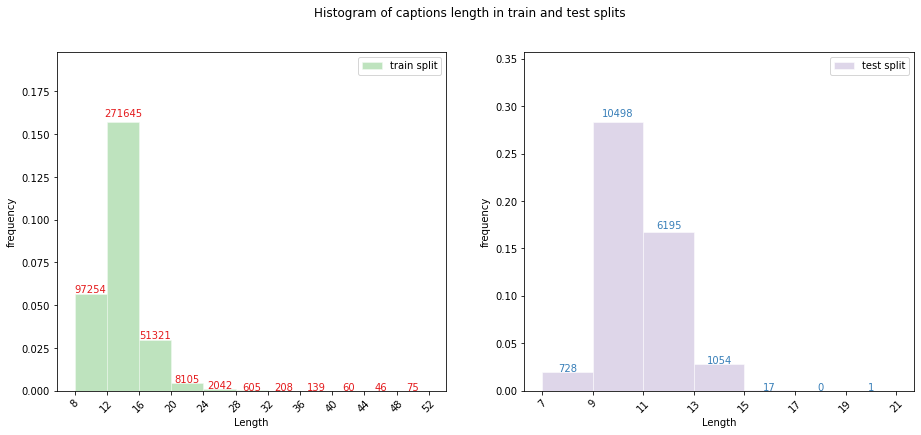

In [122]:
title = "Histogram of captions length in train and test splits "
label_x = "Length"
label_y = "frequency"
label_hist = ["train split", "test split"]
fig_data = {
    "label_h": label_hist,
    "xlabel": label_x,
    "ylabel": label_y,
    "title": title
}
figs, axes = plot_hist(data=[train_lengthes, test_lengthes],
                       fig_data=fig_data,
                       bins=[list(range(8, 53, 4)),
                             list(range(7, 22, 2))])


## Metrics analysis

Metrics calculated during test are:
  1. Cumulative bleu scores: 1 to 4 n-grams
  2. gleu score
  3. meteor score

Here I examine the mean and standard deviation for each metrics. 

In [123]:
metrics_stats_df = test_results_df.loc[:, "bleu1":].agg(["mean", "std"])
metrics_stats_str_df = metrics_stats_df.agg(
    {
        "mean": lambda x: f"{x:.4f}",
        "std": lambda x: f"{x:.3f}"
    }, axis=1).apply(" \u00B1 ".join)
metrics_stats_str_df = pd.DataFrame(metrics_stats_str_df,
                                    columns=["mean \u00B1 std"]).T

display(metrics_stats_str_df)

,bleu1,bleu2,bleu3,bleu4,gleu,meteor
mean ± std,0.7180 ± 0.171,0.5116 ± 0.226,0.3791 ± 0.227,0.2918 ± 0.215,0.2814 ± 0.174,0.4975 ± 0.193


Here we will see how the 

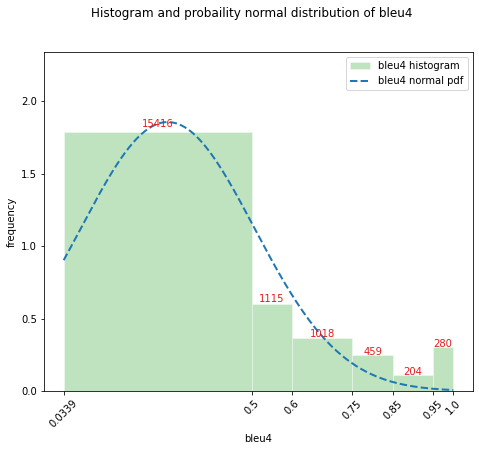

In [124]:
title = "Histogram and probaility normal distribution of bleu4"
label_x = "bleu4"
label_y = "frequency"
label_hist = "bleu4 histogram"
label_line = "bleu4 normal pdf"
fig_data = {
    "label_h": [label_hist],
    "label_l": [label_line],
    "xlabel": label_x,
    "ylabel": label_y,
    "title": title
}

bleu4 = test_results_df["bleu4"].to_numpy()
bins = [round(min(bleu4), 4), 0.5, 0.6, 0.75, 0.85, 0.95, round(max(bleu4), 4)]
fig, ax = plot_hist(data=[bleu4],
          fig_data=fig_data,
          bins=[bins],
          norm_pdf=True,
          count=True)


## Attention Visualization

In [125]:
print(np.array(test_results_df["attns"][0]).shape)
print(test_results_df["refs_text"][0])
print(test_results_df["hypos_text"][0])

(10, 14, 14)
[['A', 'woman', 'shows', 'a', 'man', 'her', 'cellphone', 'while', 'sitting', '.'], ['Two', 'women', 'are', 'sitting', 'outside', 'and', 'looking', 'at', 'a', 'phone', '.'], ['Two', 'women', 'discussing', 'a', 'cell', 'phone', 'while', 'sitting', 'on', 'a', 'garden', 'edge'], ['two', 'women', 'sitting', 'and', 'looking', 'at', 'a', 'cell', 'phone'], ['two', 'people', 'siting', 'on', 'a', 'curb', 'with', 'a', 'cell', 'phone']]
['A', 'couple', 'of', 'people', 'sitting', 'on', 'a', 'sidewalk', '.']


0.18058833479881287
0.00018288660794496536


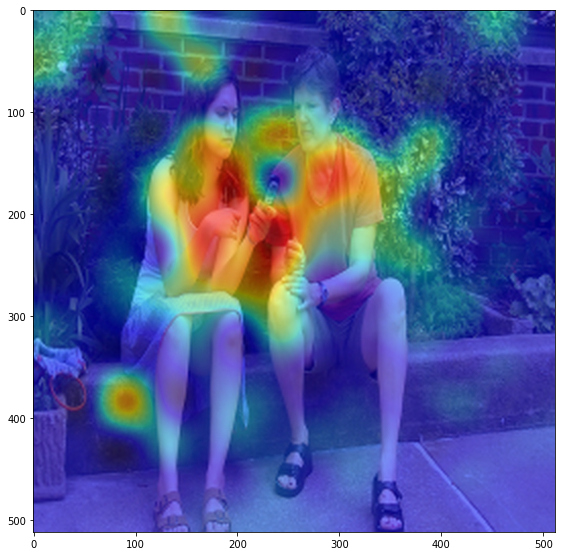

In [180]:
import matplotlib.pyplot as plt
import PIL
from PIL import Image

fig_w, fig_h = plt.rcParamsDefault["figure.figsize"]
figsize = (fig_w * 2, fig_h * 2)
figs, axes = plt.subplots(nrows=1, figsize=figsize)

attns_ = np.array(test_results_df["attns"])
max_v = -100000
min_v = 100000
for a in attns_:
    max_v = max(max_v, np.max(a))
    min_v = min(min_v, np.min(a))

print(max_v)
print(min_v)

a = Image.fromarray(np.array(attns_[0][0]))
a = np.array(a.resize((512, 512), PIL.Image.LANCZOS))
image = Image.fromarray(images[0]).resize((512, 512), PIL.Image.LANCZOS)
_ = axes.imshow(np.array(image))
_ = axes.imshow(a, alpha=0.5, interpolation="gaussian", cmap=plt.cm.jet)
